## Fruits recognition

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model, Sequential
import matplotlib.pyplot as plt
import numpy as np

#### Set constant

In [15]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=40

#### Import fruits data into tensorflow dataset object

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1212 files belonging to 6 classes.


In [17]:
class_names = dataset.class_names
print(class_names)

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


In [18]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[3 3 0 1 5 0 3 4 3 5 4 5 5 0 1 3 1 1 1 4 0 1 5 2 2 2 4 1 1 3 0 5]


### Visualize some of the images from our dataset

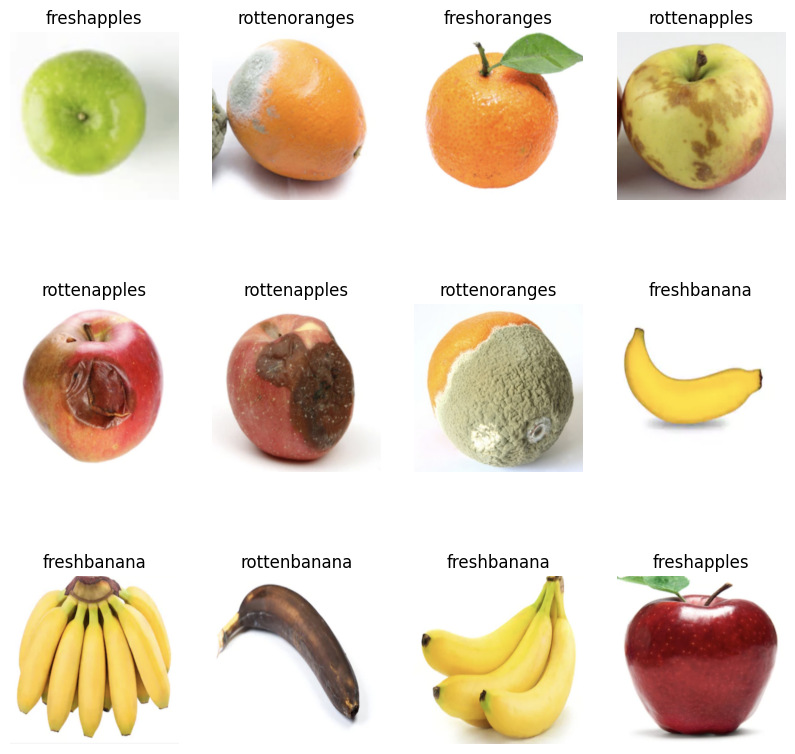

In [19]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

30

In [23]:
len(val_ds)

3

In [24]:
len(test_ds)

5

### Cache, Shuffle, and Prefetch the Dataset

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

In [26]:
IMAGE_SIZE = 224

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])


#### Data Augmentation


In [27]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

e:\fruit_vision - Copy (2)\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 10, 10, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,654 (670.52 KB)

 Trainable params: 171,654 (670.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the Model

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.2147 - loss: 1.7845 - val_accuracy: 0.3854 - val_loss: 1.6094
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4048 - loss: 1.4863 - val_accuracy: 0.5000 - val_loss: 1.0860
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5803 - loss: 1.0971 - val_accuracy: 0.5417 - val_loss: 1.0191
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6096 - loss: 1.0392 - val_accuracy: 0.6979 - val_loss: 0.7432
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7509 - loss: 0.7182 - val_accuracy: 0.8125 - val_loss: 0.6141
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7608 - loss: 0.6623 - val_accuracy: 0.8333 - val_loss: 0.5055
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7592 - loss: 0.6262 - val_accuracy: 0.7812 - val_loss: 0.5229
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 980ms/step - accuracy: 0.8223 - loss: 0.4949 - val_accuracy: 0.7812 - val_lo

In [33]:
scores = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.8942 - loss: 0.3120


Achieved 88.00% accuracy on the test dataset, which is considered a good result.


In [34]:
scores

[0.2829614579677582, 0.8999999761581421]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 30}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

40

In [40]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7561029195785522,
 1.3834550380706787,
 1.1475918292999268,
 0.9756383895874023,
 0.7322238683700562]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

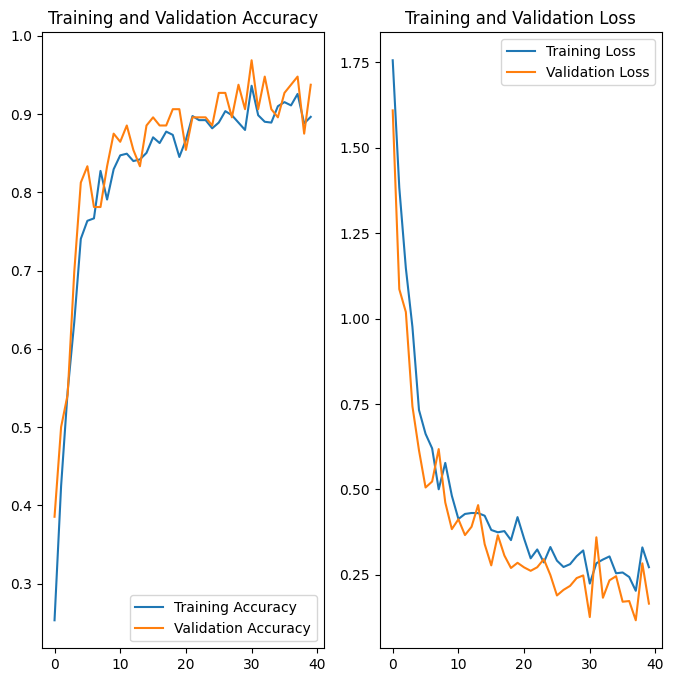

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: rottenbanana
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
predicted label: rottenbanana


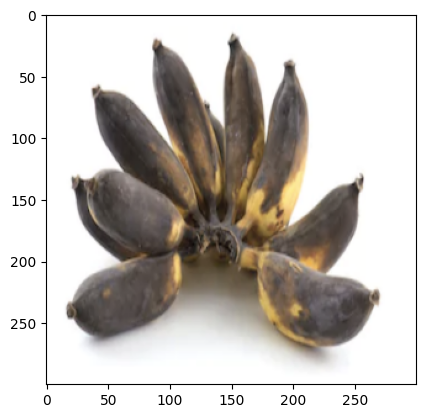

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### Write a function for inference

In [1]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample imagesNow run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


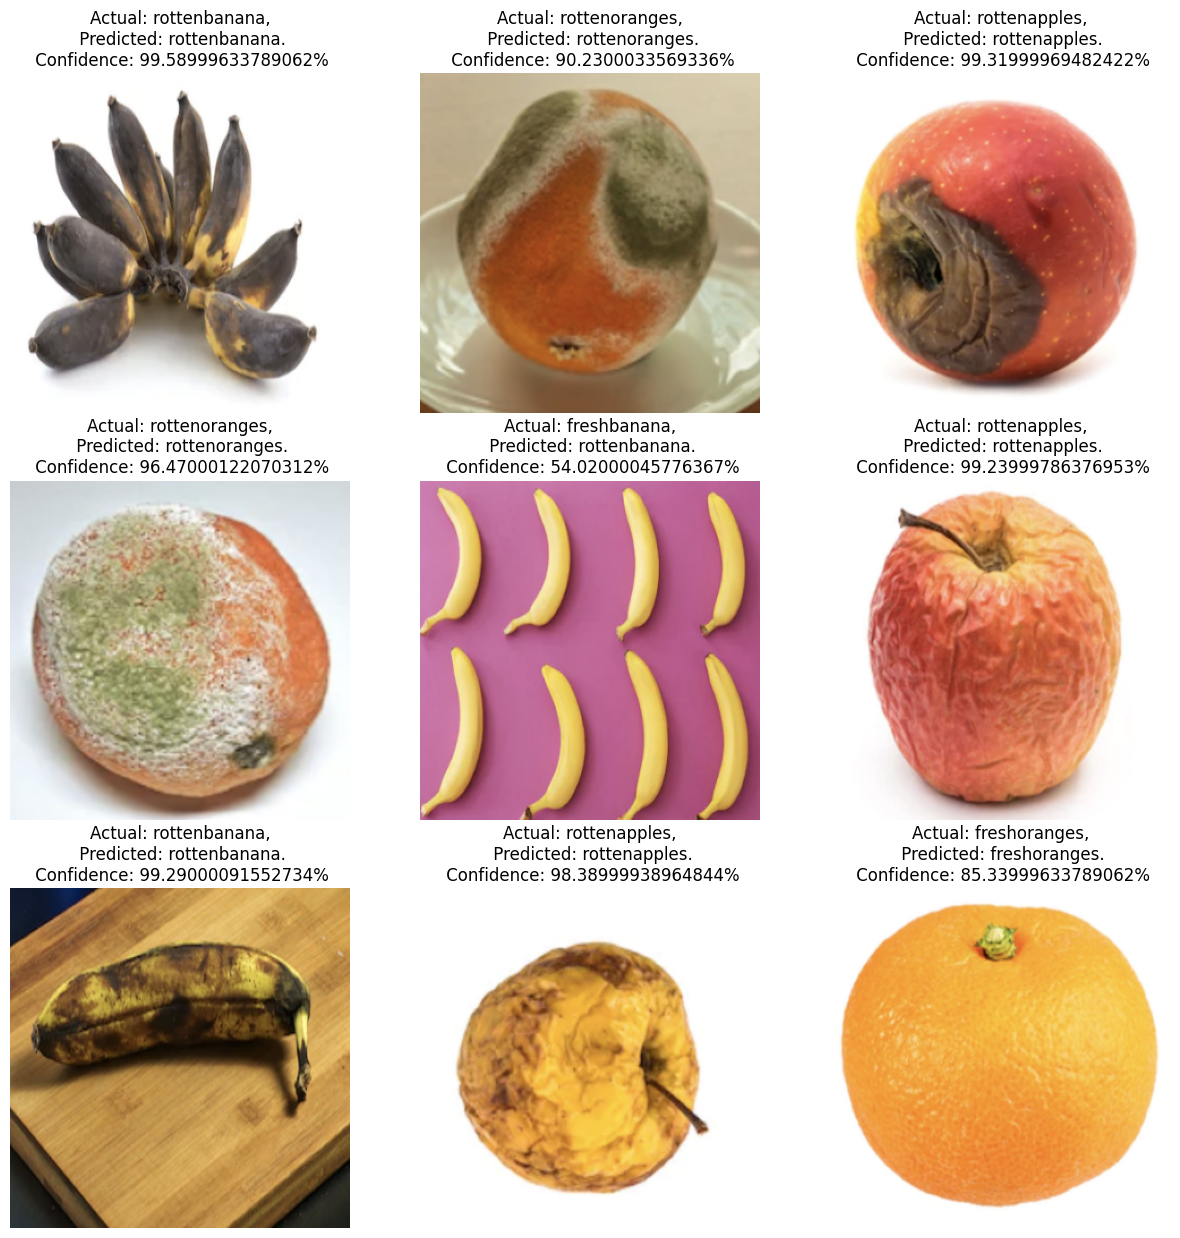

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model

In [ ]:
import os

model_dir = "models"

versions = [int(name) for name in os.listdir(model_dir) if name.isdigit()]
model_version = max(versions + [0]) + 1 

model.save(f"models/{model_version}.keras")


In [47]:
model.save("models/fruits.keras")